<center><h1><font color="blue"> Weather Image Classification with CNN models</font></h1></center>

<h2> Objectives</h2>
<ol>
    <li>Load data and data exploration</li>
    <li>Data processing</li>
    <li>CCN's models for the classification of climatic images</li>
</ol>

In [2]:
## Libraries

import os

## data management library
import pandas as pd
import numpy as np

## Timer
import time

## Data processing libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical, plot_model

## deep learning libraries
import tensorflow as tf
from keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import  BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import MaxPool2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

## Visualizing data
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import logging
tf.get_logger().setLevel(logging.ERROR)

<h1> 1.Load data and data exploration </h1>

We'll create the `weather_path` function in orden to constructs the full path of files corresponding to a specific type of weather.

**Function Purpose**:
* The purpose of this function is to generate the full path to a directory containing weather data for a given type of weather condition.


In [3]:
def weather_path(base_path, weather_type):
    '''
    Function to construct the full path of files for a specific weather type.

    Parameters:
        - base_path (str): The base directory path where weather data is stored.
        - weather_type (str): The type of weather ('Cloudy', 'Rain', 'Shine', 'Sunrise').

    Returns:
        - str: The full path to the directory corresponding to the given weather type.
    '''
    # Concatenate the base path with the weather type to form the full path
    full_path = f"{base_path}/{weather_type}"
    return full_path

In [4]:
## load the dataset getting the full path
Dataset = '/kaggle/input/multiclass-weather-dataset/Multi-class Weather Dataset/'

In [5]:
# Define access routes for different types of weather data files
Cloudy = weather_path(Dataset, 'Cloudy')
Rain = weather_path(Dataset, 'Rain')
Shine = weather_path(Dataset, 'Shine')
Sunrise = weather_path(Dataset, 'Sunrise')

<h1>Data Exploration</h1>

The `count_weather_classes` is a function wich is designed to count the number of files in each weather class directory within a specified base path.

**Function Purpose**:
* The purpose of this function is to analyze the distribution of weather data files across different weather class directories within a given base directory.

In [6]:
def count_weather_classes(base_path):
    '''
    Function to count the number of files in each weather class directory.

    Parameters:
        - base_path (str): The base directory path where weather data is stored.

    Returns:
        - pandas.DataFrame: A DataFrame containing the labels (weather classes) and the number of files in each class.
    '''
    # Get the list of directories (weather classes) in the base path
    files = os.listdir(base_path)

    # Count the number of files in each weather class directory
    num_weather = [len(os.listdir(os.path.join(base_path, x))) for x in files]

    # Create a DataFrame with labels (weather classes) and the corresponding number of files
    weather_df = pd.DataFrame({'labels': files, 'num_weather': num_weather}).sort_values('num_weather', ascending=False)

    return weather_df

In [7]:
## data frame with labels and number of samples for each climate type
weather_class_counts = count_weather_classes(Dataset)
weather_class_counts

,labels,num_weather
0,Sunrise,357
3,Cloudy,300
1,Shine,253
2,Rain,215


### Visualize data

The `bar_plot` function is designed to create a bar plot based on weather class counts stored in a DataFrame.

**Function Purpose**:
* The purpose of this function is to visualize the distribution of weather class counts using a bar plot.

In [8]:
def bar_plot(class_counts, col1, col2):
    '''
    Function to create a bar plot based on weather class counts.

    Parameters:
        - class_counts (pandas.DataFrame): DataFrame containing the weather class counts.
        - col1 (str): Name of the column in the DataFrame to use for the plot data.
        - col2 (str): Name of the column in the DataFrame to use for the plot data.
    Returns:
        - None
    '''
    plt.bar(class_counts[col1], class_counts[col2])
    plt.title('Numbers of weather type')
    plt.xlabel('Weather')
    plt.ylabel('Count')
    plt.show()

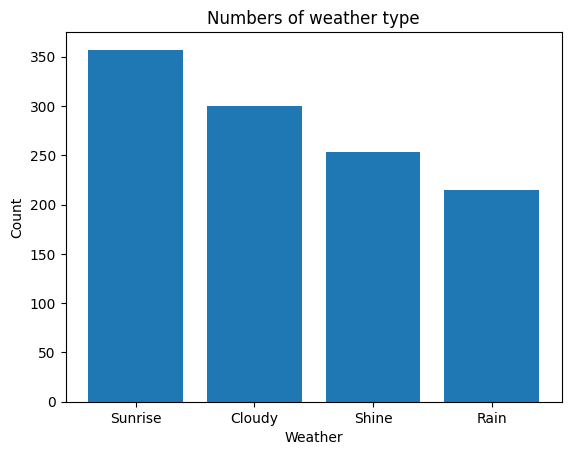

In [11]:
bar_plot(weather_class_counts,'labels', 'num_weather')

<b> Inference</b>: There is a higher number of samples of the sunrise class and a lower number of samples of the rain class.

This `view_picture` function is designed to display a sample of images from a directory along with corresponding weather type titles.

**Function Purpose**:
* The purpose of this function is to provide a visual inspection of a sample of images stored in a directory, associating them with a specified weather type.

In [10]:
def view_picture(File, weather_type):
    '''
    Function to view a sample of images in a directory with corresponding weather type titles.

    Parameters:
        - File (str): The directory path containing the images.
        - weather_type (str): The type of weather for the images.

    Returns:
        - None
    '''
    # Create a figure with a 3x3 grid of subplots
    plt.figure(figsize=(8, 8))

    # Loop through the first 9 images in the directory
    for i in range(9):
        plt.subplot(3, 3, i + 1)  # Select the next subplot
        image = plt.imread(os.path.join(File, os.listdir(File)[i]))  # Read the image
        plt.imshow(image)  # Display the image
        plt.title(weather_type)  # Set the title to the weather type

    plt.show()  # Show the plot

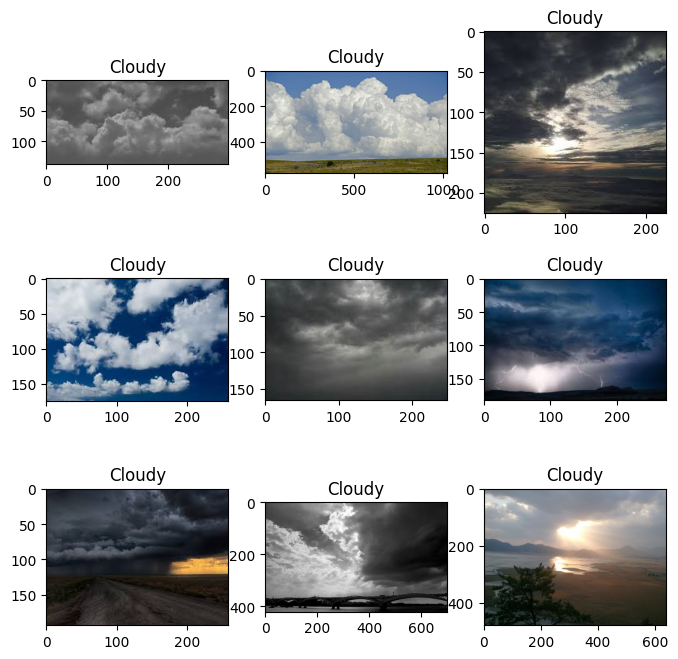

In [11]:
view_picture(Cloudy, "Cloudy")

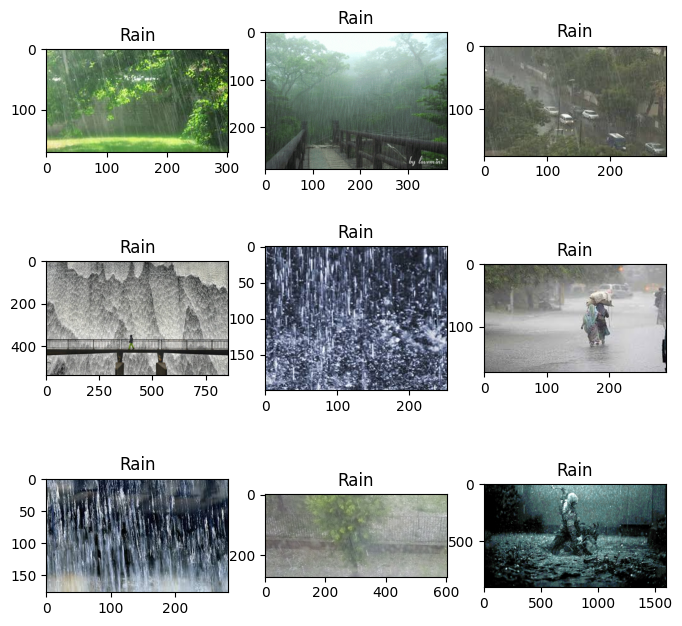

In [14]:
view_picture(Rain, "Rain")

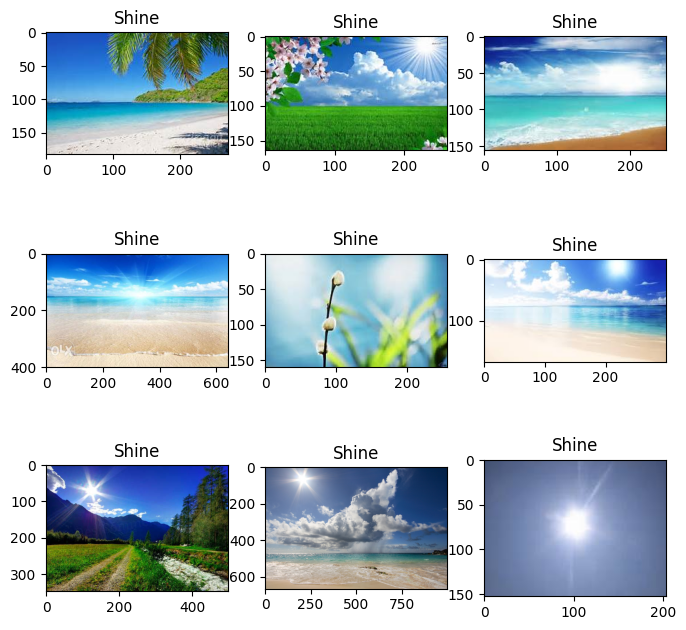

In [ ]:
view_picture(Shine, "Shine")

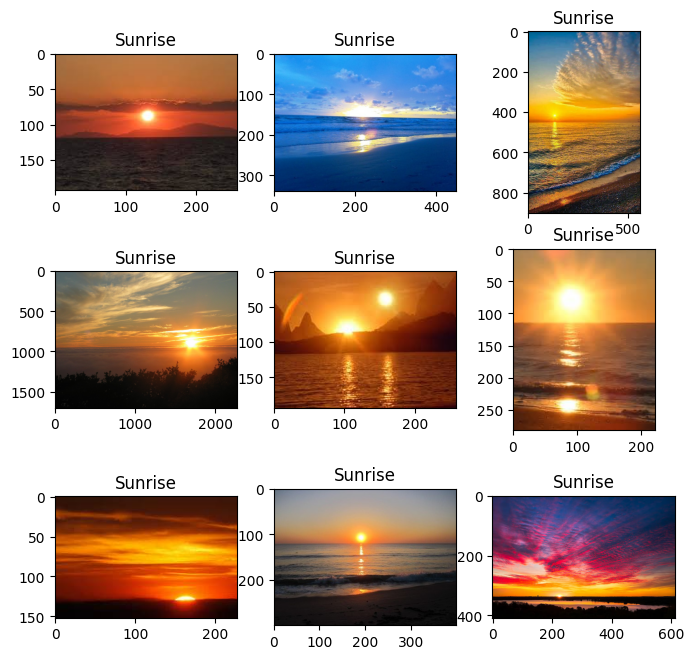

In [ ]:
view_picture(Sunrise, "Sunrise")

<b> Inference</b>: The size of the images must be adjusted

<h2> 2. Data processing</h2>

The `create_data_generators` function is designed to create data generators that can feed batches of images and their corresponding labels to a model during the training and validation phases.

In [12]:
def create_data_generators(dataset_path, target_size=(250, 250), batch_size=32, validation_split=0.2):
    '''
    Function to create data generators for training and validation.

    Parameters:
        - dataset_path (str): The directory path containing the dataset.
        - target_size (tuple): The dimensions to which all images will be resized.
        - batch_size (int): The batch size for training and validation.
        - validation_split (float): The fraction of the data to use for validation.

    Returns:
        - tuple: A tuple containing the training and validation data generators.
    '''
    # Define the image data generator with specified augmentation parameters
    data_generator = ImageDataGenerator(rescale=1. / 255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        validation_split=validation_split)

    # Create the training data generator
    train_generator = data_generator.flow_from_directory(
        dataset_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    # Create the validation data generator
    validation_generator = data_generator.flow_from_directory(
        dataset_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator

In [13]:
train_generator, validation_generator = create_data_generators(Dataset, target_size=(250, 250), batch_size=32, validation_split=0.2)

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


In [14]:
def plot_data_distribution(train_generator, validation_generator):
    '''
    Function to plot the data distribution of classes in the training and validation sets.

    Parameters:
        - train_generator: The training data generator.
        - validation_generator: The validation data generator.

    Returns:
        - None
    '''
    # Get class names and counts from the generators
    class_names = train_generator.class_indices
    train_counts = train_generator.classes.sum(axis=0)
    validation_counts = validation_generator.classes.sum(axis=0)
    labels = list(class_names.keys())

    # Set up the plot
    x = range(len(labels))
    width = 0.35
    fig, ax = plt.subplots()

    # Plot the bars for train and validation data
    train_bars = ax.bar(x, train_counts, width, label='Train Data')
    validation_bars = ax.bar([i + width for i in x], validation_counts, width, label='Validation Data')

    # Set labels and title
    ax.set_ylabel('Counts')
    ax.set_xlabel('Classes')
    ax.set_title('Data Distribution')
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(labels)
    ax.legend()

    # Show the plot
    plt.show()

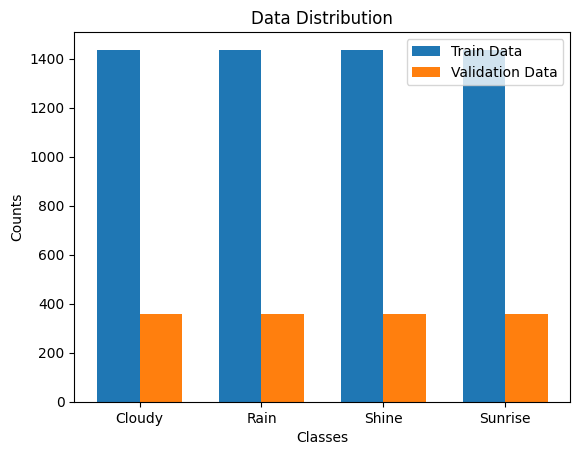

In [18]:
plot_data_distribution(train_generator, validation_generator)

In [15]:
def plot_images(images, labels):
    '''
    Function to plot images with corresponding labels.

    Parameters:
        - images (numpy.ndarray): An array of images.
        - labels (numpy.ndarray): An array of labels corresponding to the images.

    Returns:
        - None
    '''
    # Create a figure with a 3x3 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))

    # Loop through the images and labels to plot them
    for i, ax in enumerate(axes.flat):
        # Display the image
        ax.imshow(images[i])
        ax.axis('off')  # Hide axes
        # Set the title for the subplot with the corresponding label
        ax.set_title(str(labels[i]))  # Convert label to string

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [23]:
images, labels = next(train_generator)

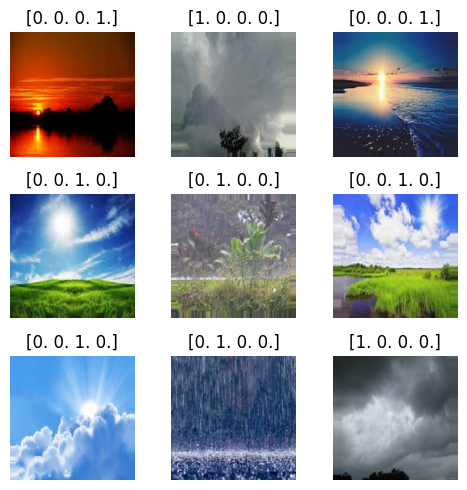

In [24]:
plot_images(images, labels)

<b> Inference</b>: The size of the images has been standardized and the same number of samples is used for each of the classes.

### 3. CNN Models

The Convolutional Cellular Neural Networks models are a type of neural network architecture inspired by both Convolutional Neural Networks (CNNs) and Cellular Neural Networks (CeNNs).

CNNs are widely used in image recognition and processing tasks due to their ability to capture spatial hierarchies in data through convolutional layers. CeNNs, on the other hand, are biologically inspired models that mimic the behavior of neurons in the brain and are particularly suited for dynamic systems and image processing tasks.

CCNs combine the strengths of both architectures. They use convolutional layers for spatial feature extraction and processing, similar to CNNs, while also incorporating the dynamic and parallel processing capabilities of CeNNs. This combination makes CCNs well-suited for tasks involving both spatial and temporal processing, such as video analysis, dynamic scene recognition, and spatiotemporal pattern recognition.

Next we are going to build some CNN models for weather classification.

## 3.1 First Model

In [16]:
def train_sequential_model(network_arch,
                           input_shape,
                           train_generator,
                           validation_generator,
                           epochs,  # Moved before batch_size
                           optimizer="adam",
                           loss="categorical_crossentropy",
                           batch_size=32,
                           steps_per_epoch=None,
                           validation_steps=None):
    """
    Function to build and train a sequential model.

    Parameters:
        - network_arch (dict): Dictionary with the following structure
            {"layer_1": {"n_units": n, "activation": activation},
             ...
             "layer_n": {"n_units": n}
            }
        - input_shape (tuple): Tuple with the shape of the input
        - train_generator: The generator for training data.
        - validation_generator: The generator for validation data.
        - optimizer (str): Name of the optimizer to use
        - loss (str): Name of the loss function to minimize
        - epochs (int): Number of epochs for training (default is 10)
        - batch_size (int): Batch size for training and validation
        - steps_per_epoch (int): Number of steps per epoch (default is None)
        - validation_steps (int): Number of steps for validation (default is None)

    Returns:
        - Compiled model
        - History object containing training history.
    """
    # Set the seed for reproducibility
    np.random.seed(123)
    tf.random.set_seed(123)

    # Create model
    model = Sequential()

    for k, layer in network_arch.items():
        n_units = layer.get("n_units")
        activation = layer.get("activation", "relu")
        if k == "layer_1":
            model.add(Conv2D(n_units, (3,3), strides=(1,1), padding='same', activation=activation, input_shape=input_shape))
        else:
            model.add(Conv2D(n_units, kernel_size=(3,3), strides=(1,1), padding='same', activation=activation))
        if 'Dropout' in layer:
            model.add(Dropout(layer['Dropout']))
        if 'MaxPool2D' in layer:
            model.add(MaxPool2D(layer['MaxPool2D']))

    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))

    # Print model summary
    print(model.summary())
    print()

    # Compile model
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # Train the model
    history = model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs=epochs,
                        batch_size=batch_size,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps)

    return model, history

In [17]:
# Define the input shape of the neural network
input_shape = (250, 250, 3)

# Define the architecture of your neural network as a dictionary
network_architecture = {
    "layer_1": {"n_units": 64, "activation": "relu"},
    "layer_2": {"n_units": 128, "activation": "relu", "Dropout": 0.3, "MaxPool2D": (2, 2)},
    "layer_3": {"n_units": 256, "activation": "relu", "Dropout": 0.3, "MaxPool2D": (2, 2)},
    "layer_4": {"n_units": 512, "activation": "relu", "Dropout": 0.3, "MaxPool2D": (2, 2)}
}

In [18]:
# Define the number of epochs, steps per epoch, and validation steps
epochs = 30 # Example number of epochs
steps_per_epoch = 901 // 32  # Example number of steps per epoch
validation_steps = 224 // 32  # Example number of validation steps

# Create and train the model
modelcnn1, history = train_sequential_model(network_architecture, input_shape, train_generator, validation_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 128)     73856     
                                                                 
 dropout (Dropout)           (None, 250, 250, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 125, 125, 128)     0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 256)     295168    
                                                                 
 dropout_1 (Dropout)         (None, 125, 125, 256)     0         
                                                        

In [19]:
def evaluate_model(model, data_generator):
    """
    Function to evaluate the model on a dataset and display the loss and accuracy.

    Parameters:
        - model: The TensorFlow/Keras model.
        - data_generator: The data generator to evaluate the model.

    Returns:
        - None
    """
    loss, accuracy = model.evaluate(data_generator)
    print(f"Loss: {loss*100:.2f}%")
    print(f"Accuracy: {accuracy*100:.2f}%")


In [20]:
result_modelccn1 = evaluate_model(modelcnn1,train_generator)

29/29 [==============================] - 15s 522ms/step - loss: 0.3343 - accuracy: 0.9034
Loss: 33.43%
Accuracy: 90.34%


In [21]:
class ModelUtilities:
    def __init__(self, model, labels):
        """
        Constructor of the ModelUtilities class.

        Parameters:
            - model: The TensorFlow/Keras model.
            - labels: The classification labels of the model.
        """
        self.model = model
        self.labels = labels

    def plot_accuracy(self, history):
        """
        Function to plot the model accuracy during training.

        Parameters:
            - history: The history object returned by the model's fit method.

        Returns:
            - None
        """
        plt.plot(history.history['accuracy'], 'r')
        plt.plot(history.history['val_accuracy'], 'b')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def plot_loss(self, history):
        """
        Function to plot the model loss during training.

        Parameters:
            - history: The history object returned by the model's fit method.

        Returns:
            - None
        """
        plt.plot(history.history['loss'], 'r')
        plt.plot(history.history['val_loss'], 'b')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def prediction(self, path_image):
        """
        Function to predict the class of a given image.

        Parameters:
            - path_image: The path of the image to be classified.

        Returns:
            - None
        """
        img = image.load_img(path_image, target_size=(250, 250))
        img = image.img_to_array(img, dtype=np.uint8)
        img = np.array(img) / 255.0

        plt.axis('off')
        plt.imshow(img.squeeze())

        predict = self.model.predict(img[np.newaxis, ...])
        predicted_class = self.labels[np.argmax(predict[0], axis=-1)]

        print('Prediction Value:', np.max(predict[0], axis=-1))
        print("Classified:", predicted_class)

In [25]:
utilities_modelcnn1 = ModelUtilities(modelcnn1, labels)

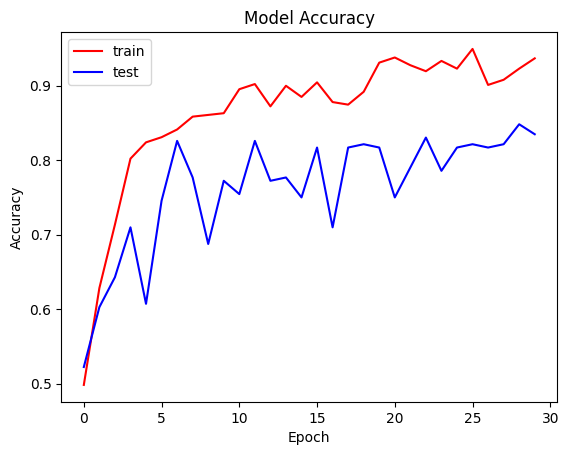

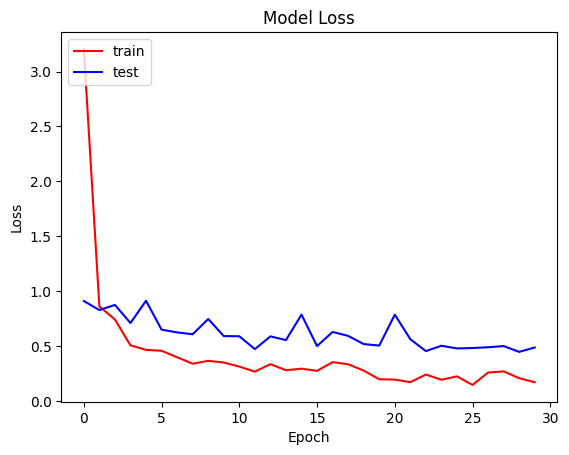

In [26]:
utilities_modelcnn1.plot_accuracy(history)
utilities_modelcnn1.plot_loss(history)

### Predictions

1/1 [==============================] - 1s 772ms/step
Prediction Value: 0.57916355
Classified: [0. 0. 0. 1.]


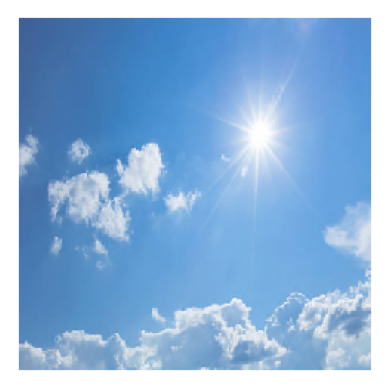

In [27]:
path_images = ['/kaggle/input/imagespredicctions/img4.png','/kaggle/input/imagespredicctions/img2.png','/kaggle/input/imagespredicctions/img1.png']
utilities_modelcnn1.prediction(path_images[0])

### 3.2 Second Model

In [28]:
# # Define la arquitectura del modelo3 como un diccionario
modelcnn2_architecture = {
    "layer_1": {"n_units": 64, "activation": "relu"},
    "layer_2": {"n_units": 128, "activation": "relu"},
    "layer_3": {"n_units": 128, "activation": "relu", "MaxPool2D": (2, 2), "Dropout": 0.3},
    "layer_4": {"n_units": 128, "activation": "relu"},
    "layer_5": {"n_units": 256, "activation": "relu"},
    "layer_6": {"n_units": 256, "activation": "relu"},
    "layer_7": {"n_units": 256, "activation": "relu", "MaxPool2D": (2, 2), "Dropout": 0.3},
    "layer_8": {"n_units": 4, "activation": "softmax"}
}

In [29]:
# Define the number of epochs, steps per epoch, and validation steps
epochs = 30
steps_per_epoch = 901 // 32
validation_steps = 224 // 32

# Create and train the model
modelcnn2, history = train_sequential_model(modelcnn2_architecture, input_shape, train_generator, validation_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 250, 250, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 250, 250, 128)     73856     
                                                                 
 conv2d_6 (Conv2D)           (None, 250, 250, 128)     147584    
                                                                 
 dropout_4 (Dropout)         (None, 250, 250, 128)     0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 125, 125, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 128)     147584    
                                                      

In [30]:
result_modelcnn2 = evaluate_model(modelcnn2,train_generator)

29/29 [==============================] - 18s 600ms/step - loss: 0.4187 - accuracy: 0.8435
Loss: 41.87%
Accuracy: 84.35%


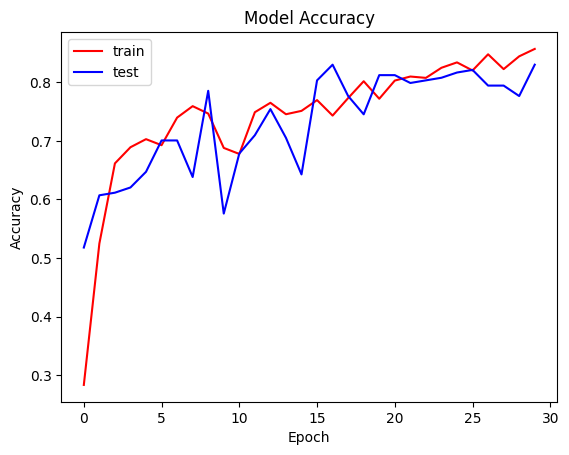

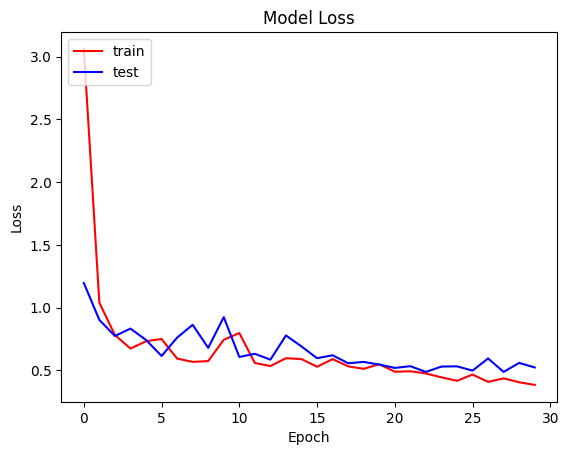

In [31]:
utilities_modelcnn2 = ModelUtilities(modelcnn2, labels)
utilities_modelcnn2.plot_accuracy(history)
utilities_modelcnn2.plot_loss(history)

1/1 [==============================] - 1s 780ms/step
Prediction Value: 0.9999889
Classified: [0. 0. 1. 0.]


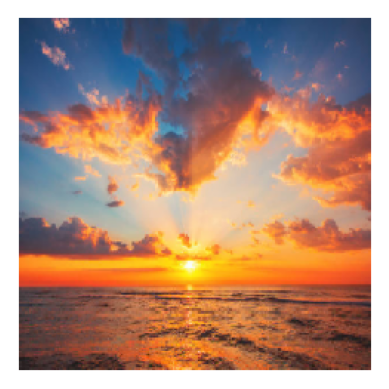

In [32]:
utilities_modelcnn2.prediction(path_images[-1])